### Import libraries

In [169]:
import sklearn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import add_dummy_feature
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDRegressor
from math import ceil
import matplotlib as mpl
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import learning_curve
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet

## Linear Regression

### Normal equation

In [181]:
np.random.seed(42)
m = 150
X = 3 * np.random.rand(m, 1)
y = 7 + 8 * X + np.random.randn(m, 1)

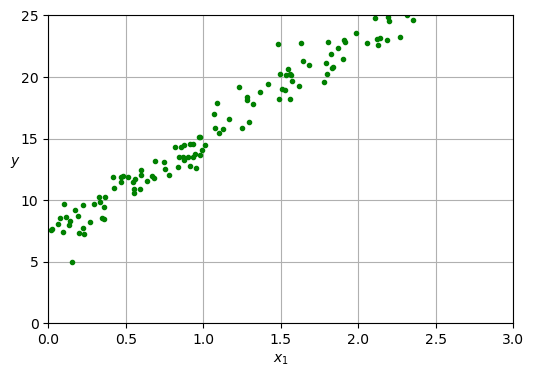

In [182]:
#plot
plt.figure(figsize=(6,4))
plt.plot(X, y, "g.")
plt.xlabel("$x_1$")
plt.ylabel("$y$", rotation=0)
plt.axis([0, 3, 0, 25])
plt.grid()
plt.show()

In [183]:
# Add a column of ones to X for the intercept term
X_b = add_dummy_feature(X)

# Compute the best parameters (theta) using the Normal Equation
theta_best = np.linalg.inv(X_b.T @ X_b) @ X_b.T @ y

# Show the optimal parameters
theta_best


array([[6.96414683],
       [8.05830223]])

In [184]:
X_new = np.array([[0], [3]])
X_new_b = add_dummy_feature(X_new)  
y_predict = X_new_b @ theta_best
y_predict

array([[ 6.96414683],
       [31.13905352]])

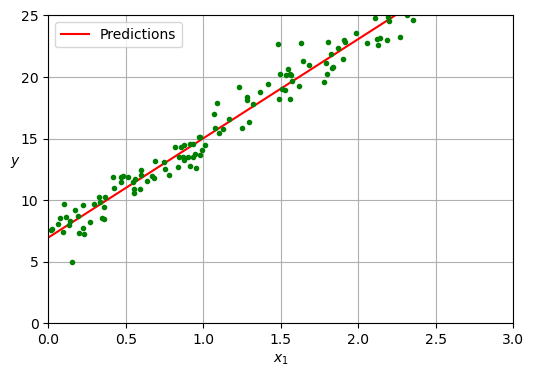

In [185]:
plt.figure(figsize=(6, 4))  # extra code – not needed, just formatting
plt.plot(X_new, y_predict, "r-", label="Predictions")
plt.plot(X, y, "g.")

# extra code – beautifies and saves Figure 4–2
plt.xlabel("$x_1$")
plt.ylabel("$y$", rotation=0)
plt.axis([0, 3, 0, 25])
plt.grid()
plt.legend(loc="upper left")

plt.show()

In [8]:
lin_reg = LinearRegression()
lin_reg.fit(X, y)
lin_reg.intercept_, lin_reg.coef_

(array([6.96414683]), array([[8.05830223]]))

In [9]:
lin_reg.predict(X_new)

array([[ 6.96414683],
       [31.13905352]])

In [10]:
theta_best_svd, residuals, rank, s = np.linalg.lstsq(X_b, y, rcond=1e-6)
theta_best_svd

array([[6.96414683],
       [8.05830223]])

In [11]:
np.linalg.pinv(X_b) @ y

array([[6.96414683],
       [8.05830223]])

# Gradient Descent

## Batch Gradient Descent

In [15]:
# Function to perform gradient descent
def gradient_descent(X_b, y, eta, n_epochs):
    m = len(X_b)
    np.random.seed(42)
    theta = np.random.randn(X_b.shape[1], 1)  # Randomly initialized model parameters
    losses = []

    for epoch in range(n_epochs):
        gradients = 2 / m * X_b.T @ (X_b @ theta - y)
        theta = theta - eta * gradients
        loss = np.mean((X_b @ theta - y) ** 2)
        losses.append(loss)

    return theta, losses

eta = 0.1  # Learning rate
n_epochs = 1000  # Number of epochs

theta, losses = gradient_descent(X_b, y, eta, n_epochs)

# Now `theta` is defined and can be printed or used further
print(theta)

[[6.96414683]
 [8.05830223]]


C:\Users\hp\AppData\Local\Temp\ipykernel_18308\383928647.py:18: RuntimeWarning: overflow encountered in matmul
  gradients = 2 / m * X_b.T @ (X_b @ theta - y)
C:\Users\hp\AppData\Local\Temp\ipykernel_18308\383928647.py:18: RuntimeWarning: invalid value encountered in matmul
  gradients = 2 / m * X_b.T @ (X_b @ theta - y)
C:\Users\hp\AppData\Local\Temp\ipykernel_18308\383928647.py:19: RuntimeWarning: invalid value encountered in subtract
  theta = theta - eta * gradients


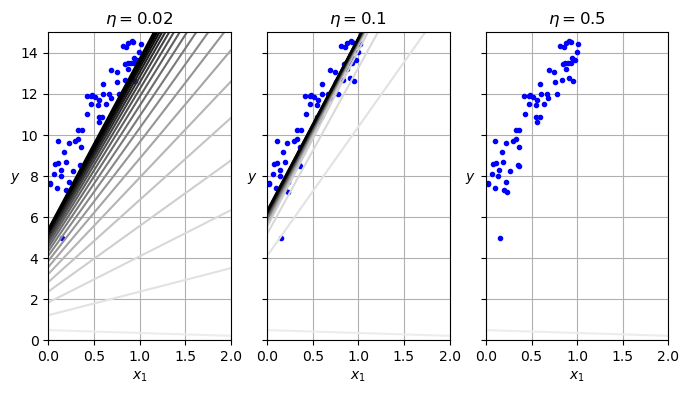

In [16]:
# Function to plot gradient descent for given learning rate (eta)
def plot_gradient_descent(theta, eta):
    m = len(X_b)
    plt.plot(X[:, 0], y, "b.")  # Plot the original data points
    n_epochs = 1000
    n_shown = 20
    theta_path = []
    
    for epoch in range(n_epochs):
        if epoch < n_shown:
            # Predictions based on current theta for visualization
            X_new_b = np.c_[np.ones((n_shown, 1)), np.linspace(0, 2, n_shown).reshape(-1, 1)]
            y_predict = X_new_b @ theta
            color = mpl.colors.rgb2hex(plt.cm.Greys(epoch / n_shown + 0.15))  # Color gradient for visualizing epochs
            plt.plot(X_new_b[:, 1], y_predict, linestyle="solid", color=color)
        
        # Calculate gradients and update theta
        gradients = 2 / m * X_b.T @ (X_b @ theta - y)
        theta = theta - eta * gradients
        theta_path.append(theta.copy())
    
    plt.xlabel("$x_1$")  # X-axis label
    plt.ylabel("$y$", rotation=0)  # Y-axis label
    plt.axis([0, 2, 0, 15])  # Set axis limits
    plt.grid()  # Enable grid
    plt.title(fr"$\eta = {eta}$")  # Plot title
    return theta_path

# Initialize theta with random values
np.random.seed(42)
theta = np.random.randn(2, 1)

# Create a figure with subplots to display gradient descent for different etas
plt.figure(figsize=(8, 4))

# Plot for eta = 0.02
plt.subplot(131)
plot_gradient_descent(theta, eta=0.02)
plt.ylabel("$y$", rotation=0)

# Plot for eta = 0.1
plt.subplot(132)
theta_path_bgd = plot_gradient_descent(theta, eta=0.1)
plt.gca().axes.yaxis.set_ticklabels([])

# Plot for eta = 0.5
plt.subplot(133)
plt.gca().axes.yaxis.set_ticklabels([])
plot_gradient_descent(theta, eta=0.5)
plt.show()


## Stochastic Gradient Descent

In [19]:
# Function to perform stochastic gradient descent
def stochastic_gradient_descent(X_b, y, eta, n_epochs):
    m = len(X_b)
    np.random.seed(42)
    theta = np.random.randn(X_b.shape[1], 1)  # Randomly initialized model parameters
    losses = []

    for epoch in range(n_epochs):
        for i in range(m):
            random_index = np.random.randint(m)
            xi = X_b[random_index:random_index+1]
            yi = y[random_index:random_index+1]
            gradients = 2 * xi.T @ (xi @ theta - yi)
            theta = theta - eta * gradients
        loss = np.mean((X_b @ theta - y) ** 2)
        losses.append(loss)

    return theta, losses

eta = 0.1  # Learning rate
n_epochs = 1000  # Number of epochs

thetaS, losses = stochastic_gradient_descent(X_b, y, eta, n_epochs)

# Now `theta` is defined and can be printed or used further
print(thetaS)


[[7.36114098]
 [7.40440817]]


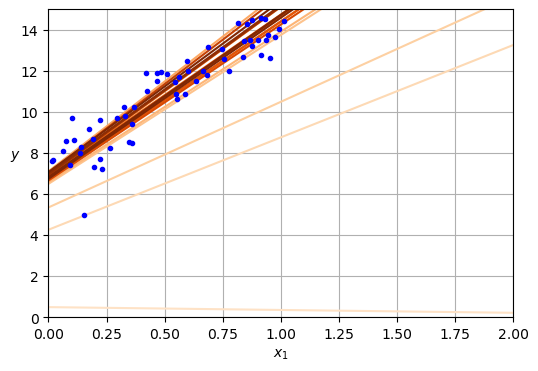

In [20]:

theta_path_sgd= []
n_epochs = 50
t0, t1 = 5, 50  # learning schedule hyperparameters

# Learning rate schedule function
def learning_schedule(t):
    return t0 / (t + t1)

np.random.seed(42)
theta = np.random.randn(2, 1)  # Random initialization of model parameters

n_shown = 20  # Number of lines to show in the plot

# Visualization setup (not essential for the actual computation)
plt.figure(figsize=(6, 4))

# Loop over epochs
for epoch in range(n_epochs):
    
    # Loop over each data point (iteration)
    for iteration in range(m):
        
        # Visualization code (for the initial lines in the plot)
        if epoch == 0 and iteration < n_shown:
            y_predict = X_new_b @ theta
            color = mpl.colors.rgb2hex(plt.cm.Oranges(iteration / n_shown + 0.15))
            plt.plot(X_new, y_predict, color=color)
        
        # Randomly select a single data point for SGD
        random_index = np.random.randint(m)
        xi = X_b[random_index : random_index + 1]
        yi = y[random_index : random_index + 1]
        
        # Compute gradients (without dividing by m for SGD)
        gradients = 2 * xi.T @ (xi @ theta - yi)
        
        # Calculate the learning rate for the current epoch and iteration
        eta = learning_schedule(epoch * m + iteration)
        
        # Update theta using the computed gradients and learning rate
        theta = theta - eta * gradients
        
        # Record theta values to visualize the path (for the figure)
        theta_path_sgd.append(theta)

# Plot the original data points (blue dots)
plt.plot(X, y, "b.")
plt.xlabel("$x_1$")
plt.ylabel("$y$", rotation=0)
plt.axis([0, 2, 0, 15])
plt.grid()
# Display the plot
plt.show()


In [21]:
sgd_reg = SGDRegressor(max_iter=1000, tol=1e-5, penalty=None, eta0=0.01,
                       n_iter_no_change=100, random_state=42)
sgd_reg.fit(X, y.ravel())  # y.ravel() because fit() expects 1D targets


SGDRegressor(n_iter_no_change=100, penalty=None, random_state=42, tol=1e-05)

In [22]:
sgd_reg.intercept_, sgd_reg.coef_

(array([6.96493671]), array([8.06026897]))

## Mini-batch gradient descent

C:\Users\hp\AppData\Local\Temp\ipykernel_18308\496106201.py:28: RuntimeWarning: overflow encountered in matmul
  gradients = 2 / minibatch_size * xi.T @ (xi @ theta - yi)
C:\Users\hp\AppData\Local\Temp\ipykernel_18308\496106201.py:28: RuntimeWarning: invalid value encountered in matmul
  gradients = 2 / minibatch_size * xi.T @ (xi @ theta - yi)
C:\Users\hp\AppData\Local\Temp\ipykernel_18308\496106201.py:29: RuntimeWarning: invalid value encountered in subtract
  theta = theta - eta * gradients


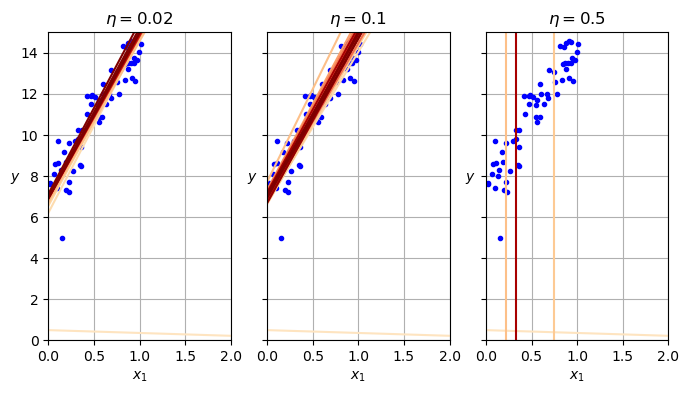

In [23]:
# Function to plot gradient descent for given learning rate (eta)
def plot_gradient_descent_minibatch(theta, eta, minibatch_size=2):
    m = len(X_b)
    plt.plot(X[:, 0], y, "b.")  # Plot the original data points
    n_epochs = 1000
    n_shown = 20
    theta_path = []

    for epoch in range(n_epochs):
        if epoch < n_shown:
            # Predictions based on current theta for visualization
            X_new_b = np.c_[np.ones((n_shown, 1)), np.linspace(0, 2, n_shown).reshape(-1, 1)]
            y_predict = X_new_b @ theta
            color = mpl.colors.rgb2hex(plt.cm.OrRd(epoch / n_shown + 0.15))  # Color gradient for visualizing epochs
            plt.plot(X_new_b[:, 1], y_predict, linestyle="solid", color=color)

        # Shuffle indices for mini-batch processing
        shuffled_indices = np.random.permutation(m)
        X_b_shuffled = X_b[shuffled_indices]
        y_shuffled = y[shuffled_indices]

        # Loop over mini-batches
        for i in range(0, m, minibatch_size):
            xi = X_b_shuffled[i:i+minibatch_size]
            yi = y_shuffled[i:i+minibatch_size]

            # Calculate gradients and update theta for mini-batch
            gradients = 2 / minibatch_size * xi.T @ (xi @ theta - yi)
            theta = theta - eta * gradients
            theta_path.append(theta.copy())

    plt.xlabel("$x_1$")  # X-axis label
    plt.ylabel("$y$", rotation=0)  # Y-axis label
    plt.axis([0, 2, 0, 15])  # Set axis limits
    plt.grid()  # Enable grid
    plt.title(fr"$\eta = {eta}$")  # Plot title
    return theta_path

# Initialize theta with random values
np.random.seed(42)
theta = np.random.randn(2, 1)

# Create a figure with subplots to display gradient descent for different etas
plt.figure(figsize=(8, 4))

# Plot for eta = 0.02
plt.subplot(131)
plot_gradient_descent_minibatch(theta, eta=0.02)
plt.ylabel("$y$", rotation=0)

# Plot for eta = 0.1
plt.subplot(132)
plot_gradient_descent_minibatch(theta, eta=0.1)
plt.gca().axes.yaxis.set_ticklabels([])

# Plot for eta = 0.5
plt.subplot(133)
plot_gradient_descent_minibatch(theta, eta=0.5)
plt.gca().axes.yaxis.set_ticklabels([])

plt.show()


# Polynomial Regression

In [24]:
np.random.seed(42)
m = 150
X = 6 * np.random.rand(m, 1) - 3
y = 0.5 * X ** 2 + X + 2 + np.random.randn(m, 1)

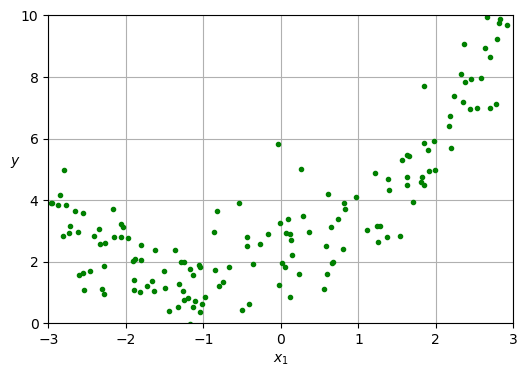

In [28]:
plt.figure(figsize=(6, 4))
plt.plot(X, y, "g.")
plt.xlabel("$x_1$")
plt.ylabel("$y$", rotation=0)
plt.axis([-3, 3, 0, 10])
plt.grid()
plt.show()

In [38]:
poly_features = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly_features.fit_transform(X)
print("X[0]= ", X[0] , "\n X polynomial = \n", X_poly )

X[0]=  [-0.75275929] 
 X polynomial = 
 [[-7.52759287e-01  5.66646544e-01]
 [ 2.70428584e+00  7.31316190e+00]
 [ 1.39196365e+00  1.93756281e+00]
 [ 5.91950905e-01  3.50405874e-01]
 [-2.06388816e+00  4.25963433e+00]
 [-2.06403288e+00  4.26023172e+00]
 [-2.65149833e+00  7.03044338e+00]
 [ 2.19705687e+00  4.82705891e+00]
 [ 6.06690070e-01  3.68072842e-01]
 [ 1.24843547e+00  1.55859111e+00]
 [-2.87649303e+00  8.27421218e+00]
 [ 2.81945911e+00  7.94934969e+00]
 [ 1.99465584e+00  3.97865194e+00]
 [-1.72596534e+00  2.97895634e+00]
 [-1.90905020e+00  3.64447265e+00]
 [-1.89957294e+00  3.60837736e+00]
 [-1.17454654e+00  1.37955958e+00]
 [ 1.48538590e-01  2.20637127e-02]
 [-4.08329888e-01  1.66733298e-01]
 [-1.25262516e+00  1.56906979e+00]
 [ 6.71117368e-01  4.50398522e-01]
 [-2.16303684e+00  4.67872835e+00]
 [-1.24713211e+00  1.55533850e+00]
 [-8.01828940e-01  6.42929649e-01]
 [-2.63580095e-01  6.94744663e-02]
 [ 1.71105577e+00  2.92771184e+00]
 [-1.80195731e+00  3.24705014e+00]
 [ 8.54066305e-

In [42]:
print("y= \n", y)

y= 
 [[ 1.33820302]
 [ 8.66241413]
 [ 4.32603328]
 [ 1.5984758 ]
 [ 3.20875182]
 [ 2.81801602]
 [ 3.65475531]
 [ 5.70119888]
 [ 4.1935208 ]
 [ 2.62587996]
 [ 3.84747015]
 [10.98458958]
 [ 4.99344549]
 [ 1.1972151 ]
 [ 2.0128375 ]
 [ 1.40114008]
 [-0.03543018]
 [ 2.22813342]
 [ 0.61273305]
 [ 2.00550217]
 [ 1.9768924 ]
 [ 3.72626175]
 [ 0.74728385]
 [ 1.19757437]
 [ 2.58467436]
 [ 3.94404737]
 [ 2.0490277 ]
 [ 3.39619653]
 [ 1.10073232]
 [ 3.16606644]
 [ 3.11333802]
 [ 2.75894597]
 [ 1.55860095]
 [ 6.99982467]
 [ 9.21837119]
 [ 5.8593294 ]
 [ 1.76533949]
 [ 2.84609999]
 [ 3.03632598]
 [ 1.93763969]
 [ 2.59669361]
 [ 1.25712876]
 [ 4.97439852]
 [ 7.94553278]
 [ 0.40874414]
 [ 4.10713019]
 [ 0.53373373]
 [ 2.91474179]
 [ 3.47813056]
 [ 1.07614527]
 [ 9.7500589 ]
 [ 5.42614314]
 [ 8.93592156]
 [ 9.07175254]
 [ 2.51453106]
 [ 6.98111091]
 [ 1.68953216]
 [ 1.02376245]
 [ 2.91698996]
 [ 1.84230484]
 [ 1.83182396]
 [ 2.39634021]
 [ 5.93065725]
 [ 2.96340701]
 [ 1.28476463]
 [ 5.00915886]
 [ 2.

In [43]:
lin_reg = LinearRegression()
lin_reg.fit(X_poly, y)
lin_reg.intercept_, lin_reg.coef_

(array([2.01256901]), array([[1.03005099, 0.5123555 ]]))

In [44]:
X_new = np.linspace(-3, 3, 150).reshape(150, 1)
X_new_poly = poly_features.transform(X_new)
y_new = lin_reg.predict(X_new_poly)

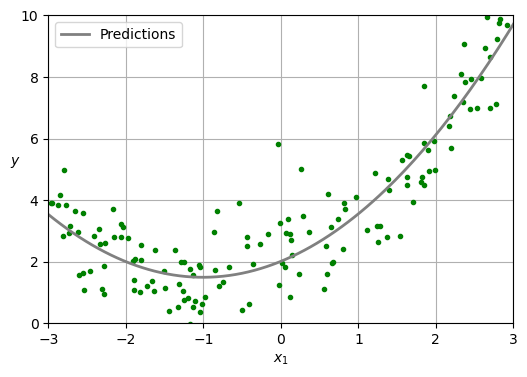

In [53]:
# Plotting
plt.figure(figsize=(6, 4))
plt.plot(X, y, "g.")
plt.plot(X_new, y_new, "grey", linewidth=2, label="Predictions")
plt.xlabel("$x_1$")
plt.ylabel("$y$", rotation=0)
plt.legend(loc="upper left")
plt.axis([-3, 3, 0, 10])
plt.grid()
plt.show()

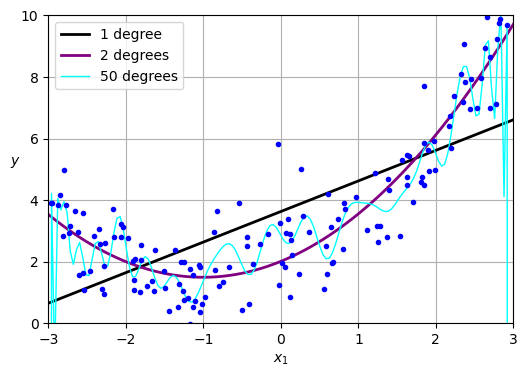

In [77]:
plt.figure(figsize=(6, 4))

for style, width, degree in (("black", 2, 1), ("purple", 2, 2), ("aqua", 1,50)):
    polybig_features = PolynomialFeatures(degree=degree, include_bias=False)
    std_scaler = StandardScaler()
    lin_reg = LinearRegression()
    polynomial_regression = make_pipeline(polybig_features, std_scaler, lin_reg)
    polynomial_regression.fit(X, y)
    y_newbig = polynomial_regression.predict(X_new)
    label = f"{degree} degree{'s' if degree > 1 else ''}"
    plt.plot(X_new, y_newbig, style, label=label, linewidth=width)

plt.plot(X, y, "b.", linewidth=3)
plt.legend(loc="upper left")
plt.xlabel("$x_1$")
plt.ylabel("$y$", rotation=0)
plt.axis([-3, 3, 0, 10])
plt.grid()
plt.show()

## Learning Curves

In [99]:
train_sizes, train_scores, valid_scores = learning_curve(
    LinearRegression(), X, y, train_sizes=np.linspace(0.01, 1.0, 40), cv=5,
    scoring="neg_root_mean_squared_error")
train_errors = -train_scores.mean(axis=1)
valid_errors = -valid_scores.mean(axis=1)

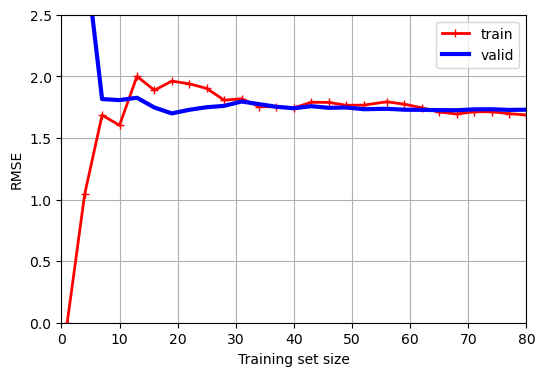

In [100]:

plt.figure(figsize=(6, 4))  # extra code – not needed, just formatting
plt.plot(train_sizes, train_errors, "r-+", linewidth=2, label="train")
plt.plot(train_sizes, valid_errors, "b-", linewidth=3, label="valid")

# extra code – beautifies and saves Figure 4–15
plt.xlabel("Training set size")
plt.ylabel("RMSE")
plt.grid()
plt.legend(loc="upper right")
plt.axis([0, 80, 0, 2.5])
plt.show()

In [101]:
# Focusing on Larger Training Sizes with Fewer Points
train_sizes, train_scores, valid_scores = learning_curve(
    LinearRegression(), X, y, train_sizes=np.linspace(0.1, 1.0, 20), cv=5,
    scoring="neg_root_mean_squared_error")
train_errors = -train_scores.mean(axis=1)
valid_errors = -valid_scores.mean(axis=1)

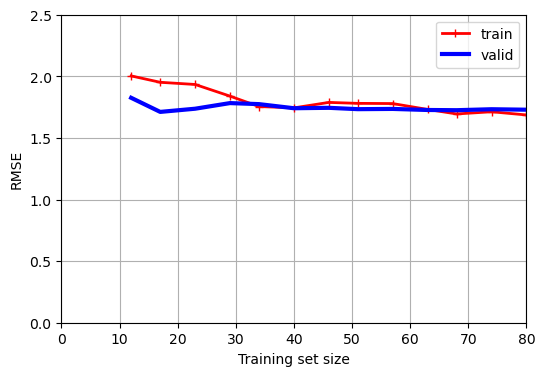

In [102]:
plt.figure(figsize=(6, 4))  # extra code – not needed, just formatting
plt.plot(train_sizes, train_errors, "r-+", linewidth=2, label="train")
plt.plot(train_sizes, valid_errors, "b-", linewidth=3, label="valid")

# extra code – beautifies and saves Figure 4–15
plt.xlabel("Training set size")
plt.ylabel("RMSE")
plt.grid()
plt.legend(loc="upper right")
plt.axis([0, 80, 0, 2.5])
plt.show()

In [103]:
#Increasing Cross-Validation Folds:
train_sizes, train_scores, valid_scores = learning_curve(
    LinearRegression(), X, y, train_sizes=np.linspace(0.01, 1.0, 40), cv=10,
    scoring="neg_root_mean_squared_error")
train_errors = -train_scores.mean(axis=1)
valid_errors = -valid_scores.mean(axis=1)

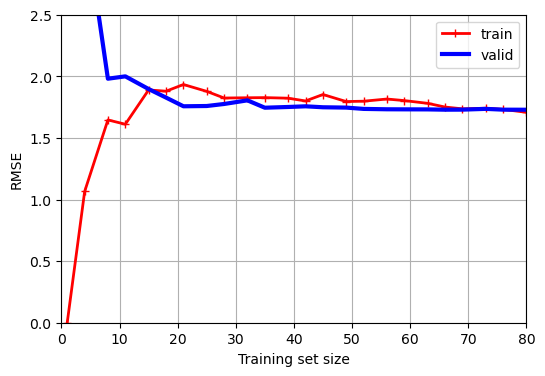

In [104]:
plt.figure(figsize=(6, 4))  # extra code – not needed, just formatting
plt.plot(train_sizes, train_errors, "r-+", linewidth=2, label="train")
plt.plot(train_sizes, valid_errors, "b-", linewidth=3, label="valid")

# extra code – beautifies and saves Figure 4–15
plt.xlabel("Training set size")
plt.ylabel("RMSE")
plt.grid()
plt.legend(loc="upper right")
plt.axis([0, 80, 0, 2.5])
plt.show()

In [106]:
#polynomial_regression
polynomial_regression = make_pipeline(
    PolynomialFeatures(degree=10, include_bias=False),
    LinearRegression())

train_sizes, train_scores, valid_scores = learning_curve(
    polynomial_regression, X, y, train_sizes=np.linspace(0.01, 1.0, 40), cv=5,
    scoring="neg_root_mean_squared_error")

train_errors = -train_scores.mean(axis=1)
valid_errors = -valid_scores.mean(axis=1)


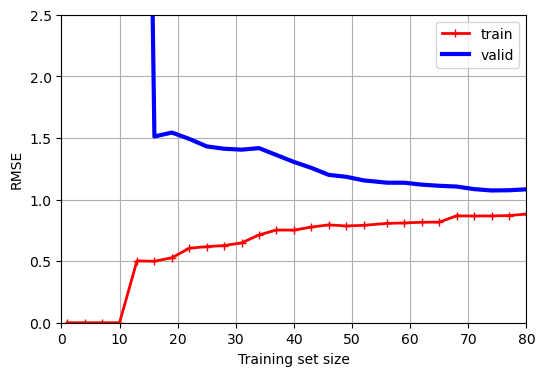

In [108]:

plt.figure(figsize=(6, 4))
plt.plot(train_sizes, train_errors, "r-+", linewidth=2, label="train")
plt.plot(train_sizes, valid_errors, "b-", linewidth=3, label="valid")
plt.legend(loc="upper right")
plt.xlabel("Training set size")
plt.ylabel("RMSE")
plt.grid()
plt.axis([0, 80, 0, 2.5])
plt.show()

# Regularized Linear Models

## Ridge Regression

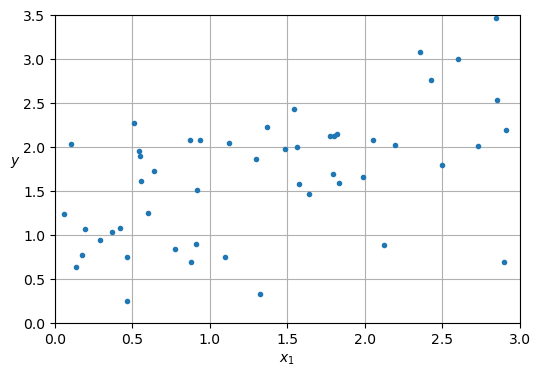

In [109]:

np.random.seed(42)
m = 50
X = 3 * np.random.rand(m, 1)
y = 1 + 0.5 * X + np.random.randn(m, 1) / 1.5
X_new = np.linspace(0, 3, 100).reshape(100, 1)

#plot
plt.figure(figsize=(6, 4))
plt.plot(X, y, ".")
plt.xlabel("$x_1$")
plt.ylabel("$y$  ", rotation=0)
plt.axis([0, 3, 0, 3.5])
plt.grid()
plt.show()

In [111]:
ridge_reg = Ridge(alpha=0.1, solver="cholesky")
ridge_reg.fit(X, y)
ridge_reg.predict([[1.5]])

array([[1.73978354]])

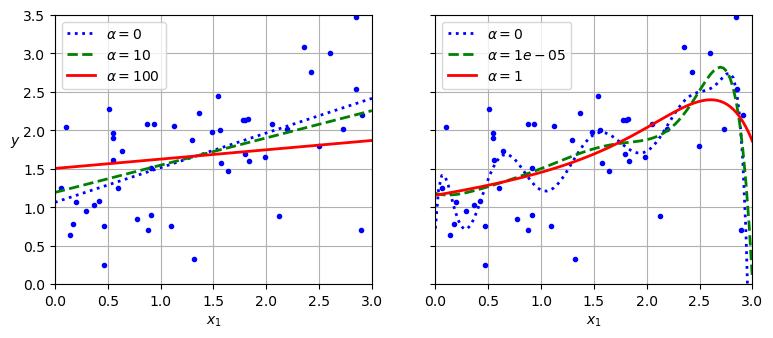

In [122]:

def plot_model(model_class, polynomial, alphas, **model_kwargs):
    plt.plot(X, y, "b.", linewidth=3)
    for alpha, style in zip(alphas, ("b:", "g--", "r-")):
        if alpha > 0:
            model = model_class(alpha, **model_kwargs)
        else:
            model = LinearRegression()
        if polynomial:
            model = make_pipeline(
                PolynomialFeatures(degree=10, include_bias=False),
                StandardScaler(),
                model)
        model.fit(X, y)
        y_new_regul = model.predict(X_new)
        plt.plot(X_new, y_new_regul, style, linewidth=2,
                 label=fr"$\alpha = {alpha}$")
    plt.legend(loc="upper left")
    plt.xlabel("$x_1$")
    plt.axis([0, 3, 0, 3.5])
    plt.grid()

plt.figure(figsize=(9, 3.5))
plt.subplot(121)
plot_model(Ridge, polynomial=False, alphas=(0, 10, 100), random_state=42)
plt.ylabel("$y$  ", rotation=0)
plt.subplot(122)
plot_model(Ridge, polynomial=True, alphas=(0, 10**-5, 1), random_state=42)
plt.gca().axes.yaxis.set_ticklabels([])
plt.show()

In [114]:
sgd_reg = SGDRegressor(penalty="l2", alpha=0.1 / m, tol=None,
                       max_iter=1000, eta0=0.01, random_state=42)
sgd_reg.fit(X, y.ravel())  # y.ravel() because fit() expects 1D targets
sgd_reg.predict([[1.5]])

array([1.7407483])

In [115]:
ridge_reg = Ridge(alpha=0.1, solver="sag", random_state=42)
ridge_reg.fit(X, y)
ridge_reg.predict([[1.5]])

array([[1.73983492]])

In [116]:
alpha = 0.1
A = np.array([[0., 0.], [0., 1.]])
X_b = np.c_[np.ones(m), X]
np.linalg.inv(X_b.T @ X_b + alpha * A) @ X_b.T @ y

array([[1.06609207],
       [0.44912764]])

In [117]:
ridge_reg.intercept_, ridge_reg.coef_

(array([1.06566837]), array([[0.44944437]]))

## Lasso Regression

In [124]:
lasso_reg = Lasso(alpha=0.1)
lasso_reg.fit(X, y)
lasso_reg.predict([[1.5]])

array([1.71794142])

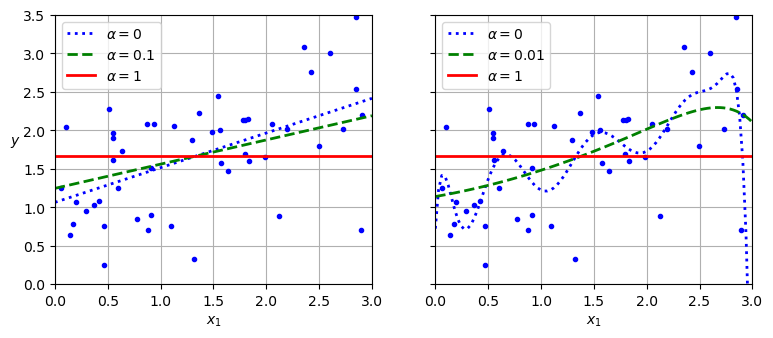

In [132]:
plt.figure(figsize=(9, 3.5))
plt.subplot(121)
plot_model(Lasso, polynomial=False, alphas=(0, 0.1, 1), random_state=42)
plt.ylabel("$y$  ", rotation=0)
plt.subplot(122)
plot_model(Lasso, polynomial=True, alphas=(0, 1e-2, 1), random_state=42)
plt.gca().axes.yaxis.set_ticklabels([])
plt.show()

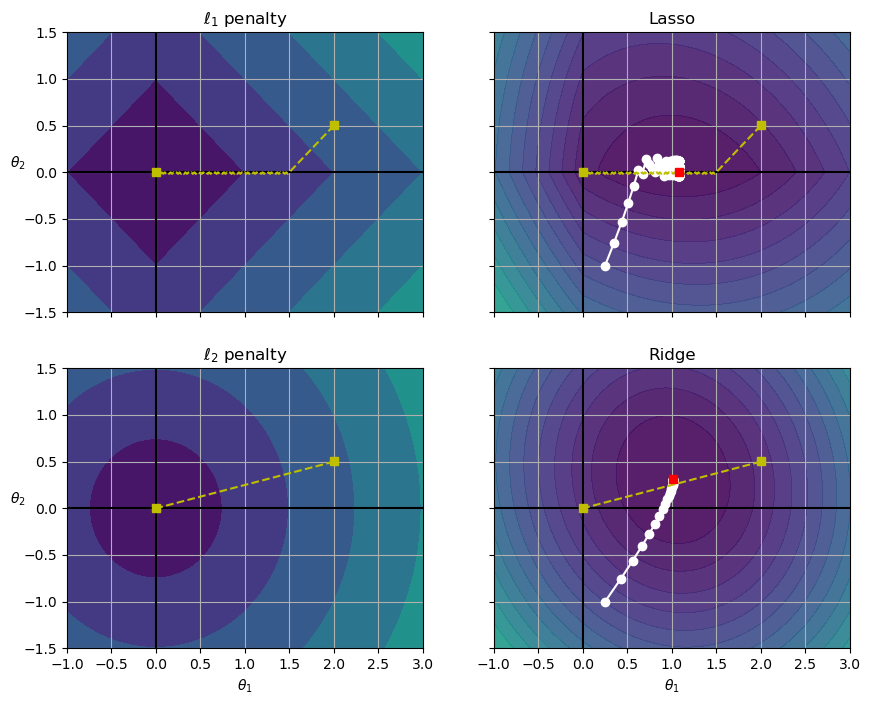

In [134]:
# Define the range for theta1 and theta2
t1a, t1b, t2a, t2b = -1, 3, -1.5, 1.5

# Create linearly spaced values for theta1 and theta2
t1s = np.linspace(t1a, t1b, 500)
t2s = np.linspace(t2a, t2b, 500)

# Create a meshgrid for theta1 and theta2
t1, t2 = np.meshgrid(t1s, t2s)

# Flatten and combine theta1 and theta2 into a single array T
T = np.c_[t1.ravel(), t2.ravel()]

# Define the input features and target values for a simple linear model
Xr = np.array([[1, 1], [1, -1], [1, 0.5]])
yr = 2 * Xr[:, :1] + 0.5 * Xr[:, 1:]

# Compute the cost function J over the grid of theta values
J = (1 / len(Xr) * ((T @ Xr.T - yr.T) ** 2).sum(axis=1)).reshape(t1.shape)

# Compute the L1 norm and L2 norm for the regularization terms
N1 = np.linalg.norm(T, ord=1, axis=1).reshape(t1.shape)
N2 = np.linalg.norm(T, ord=2, axis=1).reshape(t1.shape)

# Find the index of the minimum cost J and corresponding theta values
t_min_idx = np.unravel_index(J.argmin(), J.shape)
t1_min, t2_min = t1[t_min_idx], t2[t_min_idx]

# Initial theta values
t_init = np.array([[0.25], [-1]])

# Function to perform batch gradient descent
def bgd_path(theta, X, y, l1, l2, core=1, eta=0.05, n_iterations=200):
    path = [theta]
    for iteration in range(n_iterations):
        gradients = (core * 2 / len(X) * X.T @ (X @ theta - y)
                     + l1 * np.sign(theta) + l2 * theta)
        theta = theta - eta * gradients
        path.append(theta)
    return np.array(path)

# Create subplots for visualizing the results
fig, axes = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(10.1, 8))

# Loop through Lasso (L1) and Ridge (L2) regularization settings
for i, N, l1, l2, title in ((0, N1, 2.0, 0, "Lasso"), (1, N2, 0, 2.0, "Ridge")):
    # Compute the regularized cost function JR
    JR = J + l1 * N1 + l2 * 0.5 * N2 ** 2

    # Find the index of the minimum regularized cost JR and corresponding theta values
    tr_min_idx = np.unravel_index(JR.argmin(), JR.shape)
    t1r_min, t2r_min = t1[tr_min_idx], t2[tr_min_idx]

    # Define contour levels for plotting
    levels = np.exp(np.linspace(0, 1, 20)) - 1
    levelsJ = levels * (J.max() - J.min()) + J.min()
    levelsJR = levels * (JR.max() - JR.min()) + JR.min()
    levelsN = np.linspace(0, N.max(), 10)

    # Compute the gradient descent paths
    path_J = bgd_path(t_init, Xr, yr, l1=0, l2=0)
    path_JR = bgd_path(t_init, Xr, yr, l1, l2)
    path_N = bgd_path(theta=np.array([[2.0], [0.5]]), X=Xr, y=yr,
                      l1=np.sign(l1) / 3, l2=np.sign(l2), core=0)

    # Plot the L1 penalty contours
    ax = axes[i, 0]
    ax.grid()
    ax.axhline(y=0, color="k")
    ax.axvline(x=0, color="k")
    ax.contourf(t1, t2, N / 2.0, levels=levelsN)
    ax.plot(path_N[:, 0], path_N[:, 1], "y--")
    ax.plot(0, 0, "ys")
    ax.plot(t1_min, t2_min, "ys")
    ax.set_title(fr"$\ell_{i + 1}$ penalty")
    ax.axis([t1a, t1b, t2a, t2b])
    if i == 1:
        ax.set_xlabel(r"$\theta_1$")
    ax.set_ylabel(r"$\theta_2$", rotation=0)

    # Plot the regularized cost function contours
    ax = axes[i, 1]
    ax.grid()
    ax.axhline(y=0, color="k")
    ax.axvline(x=0, color="k")
    ax.contourf(t1, t2, JR, levels=levelsJR, alpha=0.9)
    ax.plot(path_JR[:, 0], path_JR[:, 1], "w-o")
    ax.plot(path_N[:, 0], path_N[:, 1], "y--")
    ax.plot(0, 0, "ys")
    ax.plot(t1_min, t2_min, "ys")
    ax.plot(t1r_min, t2r_min, "rs")
    ax.set_title(title)
    ax.axis([t1a, t1b, t2a, t2b])
    if i == 1:
        ax.set_xlabel(r"$\theta_1$")
plt.show()


#### Explanation
Parameter Definitions and Grid Creation:

Define the range for theta values and create linearly spaced values for them using np.linspace.
Create a meshgrid for theta values and combine them into a single array T.
Cost Function Calculation:

Define a simple linear model with features Xr and targets yr.
Compute the cost function J over the grid of theta values.
Norm Calculations:

Compute the L1 norm (N1) and L2 norm (N2) for the regularization terms.
Gradient Descent Path Calculation:

Define the initial theta values and a function bgd_path to perform batch gradient descent.
Compute gradient descent paths for different regularization settings.
Plotting:

Create subplots to visualize the results.
Loop through Lasso (L1) and Ridge (L2) regularization settings to plot the corresponding contours and paths.
Use plt.subplots to set up the figure, ax.contourf to plot filled contours, and ax.plot to plot the gradient descent paths.
display it using plt.show.

## Elastic Net

In [137]:
elastic_net = ElasticNet(alpha=0.1, l1_ratio=0.5)
elastic_net.fit(X, y)
elastic_net.predict([[1.5]])

array([1.72501526])

## When to Use Each:
### Lasso:

Use when you expect that only a subset of the features is important.
Useful for feature selection.
Can perform poorly when features are highly correlated.

### Ridge:

Use when you believe that most or all features should contribute to the model, but you want to shrink their coefficients to avoid overfitting.
Effective for handling multicollinearity.

### ElasticNet:

Use when you have a large number of features and you suspect that some, but not all, are important.
Helps when features are correlated, as it combines the strengths of both Lasso and Ridge.
Provides a balance between sparsity (feature selection) and shrinkage (coefficient reduction).

## Early Stopping

### Setup and Data Preparation

In [138]:
# Import necessary libraries
from copy import deepcopy
from sklearn.metrics import mean_squared_error

# Set random seed for reproducibility
np.random.seed(42)

# Generate synthetic quadratic dataset
m = 100
X = 6 * np.random.rand(m, 1) - 3
y = 0.5 * X ** 2 + X + 2 + np.random.randn(m, 1)

# Split the dataset into training and validation sets
X_train, y_train = X[: m // 2], y[: m // 2, 0]
X_valid, y_valid = X[m // 2 :], y[m // 2 :, 0]

# Preprocess the data: polynomial features and standard scaling
preprocessing = make_pipeline(PolynomialFeatures(degree=90, include_bias=False),
                              StandardScaler())
X_train_prep = preprocessing.fit_transform(X_train)
X_valid_prep = preprocessing.transform(X_valid)


### Model Training with Early Stopping

In [139]:
# Initialize the SGDRegressor without regularization
sgd_reg = SGDRegressor(penalty=None, eta0=0.002, random_state=42)

# Set the number of epochs and initialize variables for tracking errors
n_epochs = 500
best_valid_rmse = float('inf')
train_errors, val_errors = [] , []

# Train the model using partial_fit in a loop for early stopping
for epoch in range(n_epochs):
    sgd_reg.partial_fit(X_train_prep, y_train)
    
    # Predict on the validation set
    y_valid_predict = sgd_reg.predict(X_valid_prep)
    val_error = mean_squared_error(y_valid, y_valid_predict, squared=False)
    
    # Save the best model based on validation RMSE
    if val_error < best_valid_rmse:
        best_valid_rmse = val_error
        best_model = deepcopy(sgd_reg)

    # Track training and validation errors for plotting
    y_train_predict = sgd_reg.predict(X_train_prep)
    train_error = mean_squared_error(y_train, y_train_predict, squared=False)
    val_errors.append(val_error)
    train_errors.append(train_error)


### Plotting the Training and Validation Errors

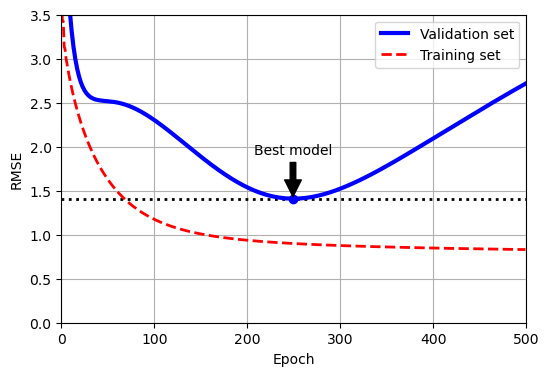

In [141]:
# Identify the epoch with the best validation error
best_epoch = np.argmin(val_errors)

# Plot training and validation errors over epochs
plt.figure(figsize=(6, 4))
plt.annotate('Best model',
             xy=(best_epoch, best_valid_rmse),
             xytext=(best_epoch, best_valid_rmse + 0.5),
             ha="center",
             arrowprops=dict(facecolor='black', shrink=0.05))
plt.plot([0, n_epochs], [best_valid_rmse, best_valid_rmse], "k:", linewidth=2)
plt.plot(val_errors, "b-", linewidth=3, label="Validation set")
plt.plot(best_epoch, best_valid_rmse, "bo")
plt.plot(train_errors, "r--", linewidth=2, label="Training set")
plt.legend(loc="upper right")
plt.xlabel("Epoch")
plt.ylabel("RMSE")
plt.axis([0, n_epochs, 0, 3.5])
plt.grid()
plt.show()


## When to Use This Code
### Overfitting Prevention:
When you want to prevent overfitting by stopping the training process early if the validation error starts to increase.
### Model Selection:
When you need to select the best model based on validation performance.
### Monitoring Training:
To monitor the training process and visualize the training and validation errors to make informed decisions about the training duration.

# Logistic Regression

## Estimating Probabilities

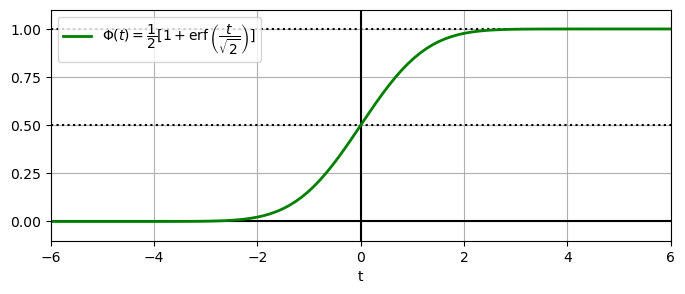

In [143]:
from scipy.stats import norm

# Set the range for t values
lim = 6
t = np.linspace(-lim, lim, 100)

# Calculate the CDF values
cdf = norm.cdf(t)

# Plot the Normal CDF
plt.figure(figsize=(8, 3))
plt.plot([-lim, lim], [0, 0], "k-")
plt.plot([-lim, lim], [0.5, 0.5], "k:")
plt.plot([-lim, lim], [1, 1], "k:")
plt.plot([0, 0], [-0.1, 1.1], "k-")
plt.plot(t, cdf, "g-", linewidth=2, label=r"$\Phi(t) = \dfrac{1}{2}[1 + \operatorname{erf}\left(\dfrac{t}{\sqrt{2}}\right)]$")
plt.xlabel("t")
plt.legend(loc="upper left")
plt.axis([-lim, lim, -0.1, 1.1])
plt.gca().set_yticks([0, 0.25, 0.5, 0.75, 1])
plt.grid()
plt.show()


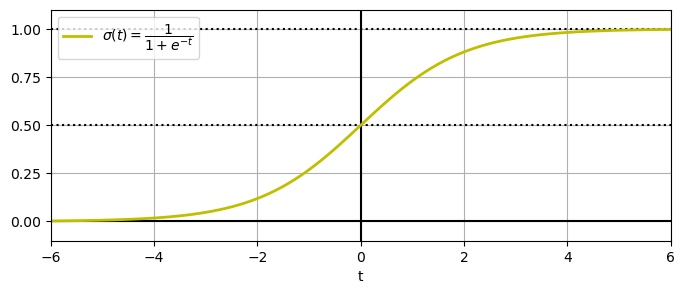

In [145]:
lim = 6
t = np.linspace(-lim, lim, 100)
sig = 1 / (1 + np.exp(-t))

plt.figure(figsize=(8, 3))
plt.plot([-lim, lim], [0, 0], "k-")
plt.plot([-lim, lim], [0.5, 0.5], "k:")
plt.plot([-lim, lim], [1, 1], "k:")
plt.plot([0, 0], [-1.1, 1.1], "k-")
plt.plot(t, sig, "y-", linewidth=2, label=r"$\sigma(t) = \dfrac{1}{1 + e^{-t}}$")
plt.xlabel("t")
plt.legend(loc="upper left")
plt.axis([-lim, lim, -0.1, 1.1])
plt.gca().set_yticks([0, 0.25, 0.5, 0.75, 1])
plt.grid()
plt.show()

## Decision Boundaries using SVM

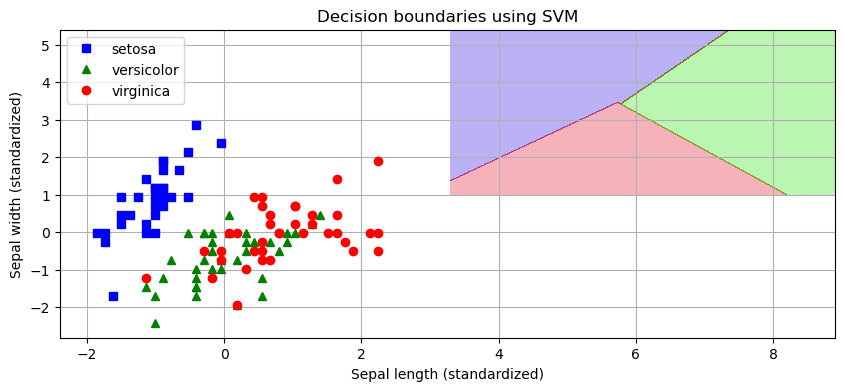

In [146]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

# Load the Iris dataset
iris = load_iris()
X = iris.data[:, :2]  # use only the first two features for visualization
y = iris.target

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Train an SVM classifier
svm_clf = SVC(kernel='linear', C=1.0, random_state=42)
svm_clf.fit(X_train, y_train)

# Create a mesh to plot the decision boundaries
x0, x1 = np.meshgrid(np.linspace(X[:, 0].min() - 1, X[:, 0].max() + 1, 500),
                     np.linspace(X[:, 1].min() - 1, X[:, 1].max() + 1, 500))
X_new = np.c_[x0.ravel(), x1.ravel()]
X_new = scaler.transform(X_new)  # apply the same scaling
y_predict = svm_clf.predict(X_new)
zz = y_predict.reshape(x0.shape)

# Plot the decision boundaries
plt.figure(figsize=(10, 4))
plt.contourf(x0, x1, zz, alpha=0.3, cmap=plt.cm.brg)
plt.plot(X_train[y_train == 0, 0], X_train[y_train == 0, 1], "bs", label=iris.target_names[0])
plt.plot(X_train[y_train == 1, 0], X_train[y_train == 1, 1], "g^", label=iris.target_names[1])
plt.plot(X_train[y_train == 2, 0], X_train[y_train == 2, 1], "ro", label=iris.target_names[2])
plt.xlabel("Sepal length (standardized)")
plt.ylabel("Sepal width (standardized)")
plt.legend(loc="upper left")
plt.axis("tight")
plt.title("Decision boundaries using SVM")
plt.grid()
plt.show()


## Decision Boundaries

In [153]:
from sklearn.datasets import load_iris

iris = load_iris(as_frame=True)
list(iris)

['data',
 'target',
 'frame',
 'target_names',
 'DESCR',
 'feature_names',
 'filename',
 'data_module']

In [154]:
print(iris.DESCR) 

.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

    :Number of Instances: 150 (50 in each of three classes)
    :Number of Attributes: 4 numeric, predictive attributes and the class
    :Attribute Information:
        - sepal length in cm
        - sepal width in cm
        - petal length in cm
        - petal width in cm
        - class:
                - Iris-Setosa
                - Iris-Versicolour
                - Iris-Virginica
                
    :Summary Statistics:

    ============== ==== ==== ======= ===== ====================
                    Min  Max   Mean    SD   Class Correlation
    ============== ==== ==== ======= ===== ====================
    sepal length:   4.3  7.9   5.84   0.83    0.7826
    sepal width:    2.0  4.4   3.05   0.43   -0.4194
    petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
    petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
    ============== ==== ==== ======= ===== ===========

In [155]:
iris.data.head(3)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2


In [156]:
iris.target.head(3) 

0    0
1    0
2    0
Name: target, dtype: int32

In [157]:
iris.target_names

array(['setosa', 'versicolor', 'virginica'], dtype='<U10')

In [158]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

X = iris.data[["petal width (cm)"]].values
y = iris.target_names[iris.target] == 'virginica'
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

log_reg = LogisticRegression(random_state=42)
log_reg.fit(X_train, y_train)

X_new = np.linspace(0, 3, 1000).reshape(-1, 1)  # reshape to get a column vector
y_proba = log_reg.predict_proba(X_new)
decision_boundary = X_new[y_proba[:, 1] >= 0.5][0, 0]


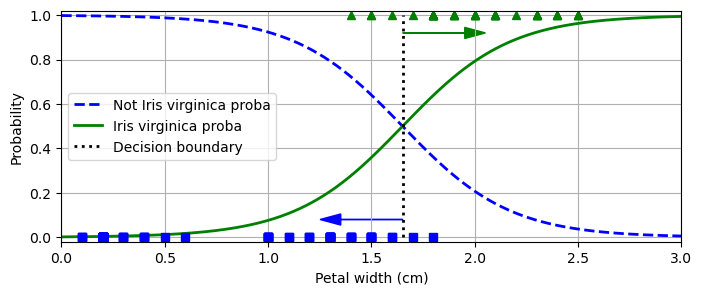

In [159]:
plt.figure(figsize=(8, 3))  # extra code – not needed, just formatting
plt.plot(X_new, y_proba[:, 0], "b--", linewidth=2,
         label="Not Iris virginica proba")
plt.plot(X_new, y_proba[:, 1], "g-", linewidth=2, label="Iris virginica proba")
plt.plot([decision_boundary, decision_boundary], [0, 1], "k:", linewidth=2,
         label="Decision boundary")

# extra code – this section beautifies and saves Figure 4–23
plt.arrow(x=decision_boundary, y=0.08, dx=-0.3, dy=0,
          head_width=0.05, head_length=0.1, fc="b", ec="b")
plt.arrow(x=decision_boundary, y=0.92, dx=0.3, dy=0,
          head_width=0.05, head_length=0.1, fc="g", ec="g")
plt.plot(X_train[y_train == 0], y_train[y_train == 0], "bs")
plt.plot(X_train[y_train == 1], y_train[y_train == 1], "g^")
plt.xlabel("Petal width (cm)")
plt.ylabel("Probability")
plt.legend(loc="center left")
plt.axis([0, 3, -0.02, 1.02])
plt.grid()

plt.show()

In [160]:
log_reg.predict([[1.7], [1.5]])

array([ True, False])

In [161]:

X = iris.data[["petal length (cm)", "petal width (cm)"]].values
y = iris.target_names[iris.target] == 'virginica'
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

log_reg = LogisticRegression(C=2, random_state=42)
log_reg.fit(X_train, y_train)

LogisticRegression(C=2, random_state=42)

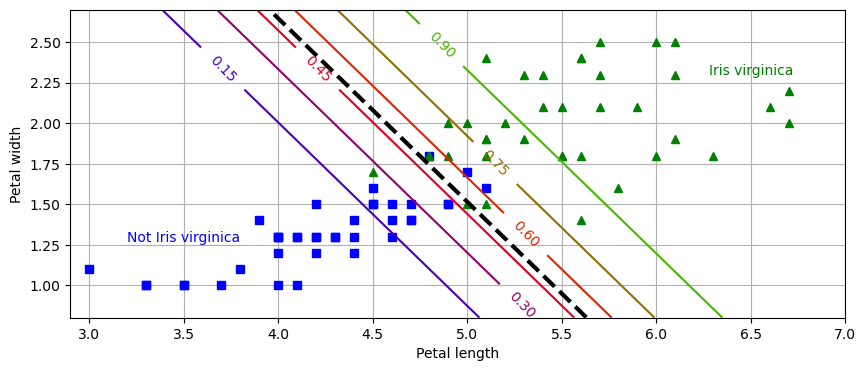

In [162]:
# for the contour plot
x0, x1 = np.meshgrid(np.linspace(2.9, 7, 500).reshape(-1, 1),
                     np.linspace(0.8, 2.7, 200).reshape(-1, 1))
X_new = np.c_[x0.ravel(), x1.ravel()]  # one instance per point on the figure
y_proba = log_reg.predict_proba(X_new)
zz = y_proba[:, 1].reshape(x0.shape)

# for the decision boundary
left_right = np.array([2.9, 7])
boundary = -((log_reg.coef_[0, 0] * left_right + log_reg.intercept_[0])
             / log_reg.coef_[0, 1])

plt.figure(figsize=(10, 4))
plt.plot(X_train[y_train == 0, 0], X_train[y_train == 0, 1], "bs")
plt.plot(X_train[y_train == 1, 0], X_train[y_train == 1, 1], "g^")
contour = plt.contour(x0, x1, zz, cmap=plt.cm.brg)
plt.clabel(contour, inline=1)
plt.plot(left_right, boundary, "k--", linewidth=3)
plt.text(3.5, 1.27, "Not Iris virginica", color="b", ha="center")
plt.text(6.5, 2.3, "Iris virginica", color="g", ha="center")
plt.xlabel("Petal length")
plt.ylabel("Petal width")
plt.axis([2.9, 7, 0.8, 2.7])
plt.grid()
plt.show()

## Softmax Regression with iris database

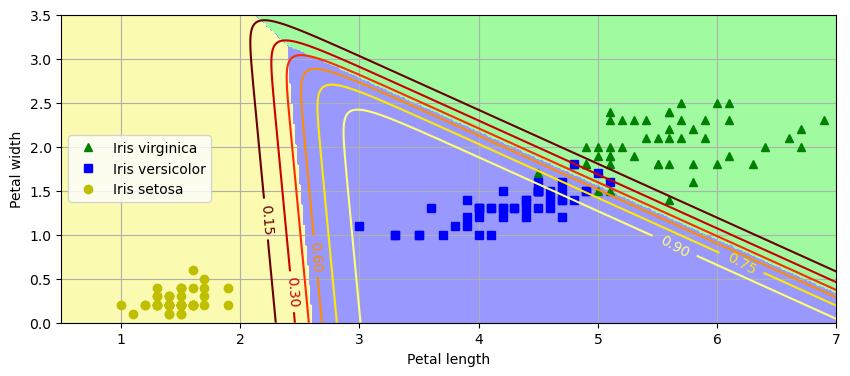

In [152]:
## Softmax Regression

X = iris.data[["petal length (cm)", "petal width (cm)"]].values
y = iris["target"]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

softmax_reg = LogisticRegression(C=30, random_state=42)
softmax_reg.fit(X_train, y_train)

softmax_reg.predict([[5, 2]])

softmax_reg.predict_proba([[5, 2]]).round(2)

# extra code – this cell generates and saves Figure 4–25

from matplotlib.colors import ListedColormap

custom_cmap = ListedColormap(["#fafab0", "#9898ff", "#a0faa0"])

x0, x1 = np.meshgrid(np.linspace(0, 8, 500).reshape(-1, 1),
                     np.linspace(0, 3.5, 200).reshape(-1, 1))
X_new = np.c_[x0.ravel(), x1.ravel()]

y_proba = softmax_reg.predict_proba(X_new)
y_predict = softmax_reg.predict(X_new)

zz1 = y_proba[:, 1].reshape(x0.shape)
zz = y_predict.reshape(x0.shape)

plt.figure(figsize=(10, 4))
plt.plot(X[y == 2, 0], X[y == 2, 1], "g^", label="Iris virginica")
plt.plot(X[y == 1, 0], X[y == 1, 1], "bs", label="Iris versicolor")
plt.plot(X[y == 0, 0], X[y == 0, 1], "yo", label="Iris setosa")

plt.contourf(x0, x1, zz, cmap=custom_cmap)
contour = plt.contour(x0, x1, zz1, cmap="hot")
plt.clabel(contour, inline=1)
plt.xlabel("Petal length")
plt.ylabel("Petal width")
plt.legend(loc="center left")
plt.axis([0.5, 7, 0, 3.5])
plt.grid()
save_fig("softmax_regression_contour_plot")
plt.show()

### Softmax Regression with Wine Dataset

[0]
[[1. 0. 0.]]


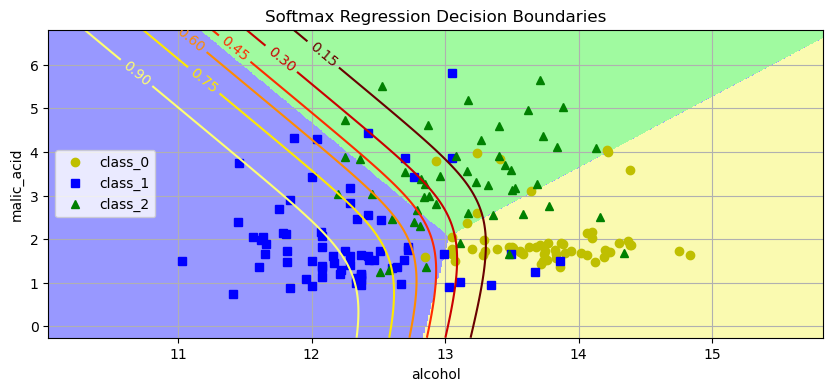

In [163]:
from sklearn.datasets import load_wine
from matplotlib.colors import ListedColormap

# Load the Wine dataset
wine = load_wine()
X = wine.data[:, :2]  # use only the first two features for visualization
y = wine.target

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Train a Softmax regression classifier
softmax_reg = LogisticRegression(multi_class="multinomial", solver="lbfgs", C=10, random_state=42)
softmax_reg.fit(X_train, y_train)

# Predict a new sample
print(softmax_reg.predict([[13, 2]]))
print(softmax_reg.predict_proba([[13, 2]]).round(2))

# Create a mesh to plot the decision boundaries
x0, x1 = np.meshgrid(np.linspace(X[:, 0].min() - 1, X[:, 0].max() + 1, 500),
                     np.linspace(X[:, 1].min() - 1, X[:, 1].max() + 1, 500))
X_new = np.c_[x0.ravel(), x1.ravel()]
X_new = scaler.transform(X_new)  # apply the same scaling

# Predict probabilities for the mesh grid
y_proba = softmax_reg.predict_proba(X_new)
y_predict = softmax_reg.predict(X_new)

zz1 = y_proba[:, 1].reshape(x0.shape)
zz = y_predict.reshape(x0.shape)

# Plot the decision boundaries
custom_cmap = ListedColormap(["#fafab0", "#9898ff", "#a0faa0"])
plt.figure(figsize=(10, 4))
plt.plot(X[y == 0, 0], X[y == 0, 1], "yo", label=wine.target_names[0])
plt.plot(X[y == 1, 0], X[y == 1, 1], "bs", label=wine.target_names[1])
plt.plot(X[y == 2, 0], X[y == 2, 1], "g^", label=wine.target_names[2])

plt.contourf(x0, x1, zz, cmap=custom_cmap)
contour = plt.contour(x0, x1, zz1, cmap="hot")
plt.clabel(contour, inline=1)
plt.xlabel(wine.feature_names[0])
plt.ylabel(wine.feature_names[1])
plt.legend(loc="center left")
plt.axis([X[:, 0].min() - 1, X[:, 0].max() + 1, X[:, 1].min() - 1, X[:, 1].max() + 1])
plt.grid()
plt.title("Softmax Regression Decision Boundaries")
plt.show()
